In [59]:
from llm import ollama_model, watsonx_model
import os 
from dotenv import load_dotenv

load_dotenv()
llm = ollama_model

## SQL Test

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///./database/app.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM users LIMIT 5;")}')

Dialect: sqlite
Available tables: ['service_tiers', 'services', 'subscriptions', 'transactions', 'users']
Sample output: [(1, 'alice@example.com', 'Alice', 'Smith', '1234567890'), (2, 'bob@example.com', 'Bob', 'Jones', '9876543210'), (3, 'carol@example.com', 'Carol', 'Taylor', '5551234567')]


In [3]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [4]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode



get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="auto")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}





def generate_query(state: MessagesState):
    generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

{input_question}
""".format(
    dialect=db.dialect,
    top_k=5,
    input_question=state["messages"][-1].content,
)
    user_message = {
        "role": "user",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([user_message])
    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
    - Using NOT IN with NULL values
    - Using UNION when UNION ALL should have been used
    - Using BETWEEN for exclusive ranges
    - Data type mismatch in predicates
    - Properly quoting identifiers
    - Using the correct number of arguments for functions
    - Casting to the correct data type
    - Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="auto")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id
    return {"messages": [response]}

# State (The data that gets pass between nodes)

In [ ]:
from __future__ import annotations

from dataclasses import dataclass, field
from typing import TypedDict

from langgraph.graph import add_messages
from typing_extensions import Annotated


import operator


class OverallState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: int 
    firstName: str
    lastName: str
    subscriptions: Annotated[list, operator.add] 
    web_search_count: int
    # search_query: Annotated[list, operator.add]
    # web_research_result: Annotated[list, operator.add]
    # sources_gathered: Annotated[list, operator.add]
    # initial_search_query_count: int
    # max_research_loops: int
    # research_loop_count: int
    # reasoning_model: str

# Confiugrations

In [60]:

import os
from pydantic import BaseModel, Field
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig

class Configuration(BaseModel):
    """The configuration for the agent."""

    maximum_web_search: int = Field(
        default=4,
        metadata={"description": "The maximum number of web search queries to generate."},
    )
    


    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )

        # Get raw values from environment or config
        raw_values: dict[str, Any] = {
            name: os.environ.get(name.upper(), configurable.get(name))
            for name in cls.model_fields.keys()
        }

        # Filter out None values
        values = {k: v for k, v in raw_values.items() if v is not None}

        return cls(**values)

# Get specific user's subscription information when recieve the User_ID and questions

In [61]:
from database.database import SessionLocal
from sqlalchemy import text
db = SessionLocal()
user_id = 2
out = db.execute(text(f"""SELECT 
    u.id as user_id,
    u.email,
    u.firstName,
    u.lastName,
    s.start_date as subscription_start,
    s.current_status as subscription_status,
    st.tier_name,
    st.price_usd,
    sv.name as service_name,
    sv.category
FROM users u
LEFT JOIN subscriptions s ON u.id = s.user_id
LEFT JOIN service_tiers st ON s.tier_id = st.id
LEFT JOIN services sv ON st.service_id = sv.id
WHERE u.id = {user_id};"""))

rows_as_dicts = [row._asdict() for row in out]

for row_dict in rows_as_dicts:
    print(row_dict)



{'user_id': 2, 'email': 'bob@example.com', 'firstName': 'Bob', 'lastName': 'Jones', 'subscription_start': '2023-01-11', 'subscription_status': 'cancelled', 'tier_name': 'Standard with Ads', 'price_usd': 6.99, 'service_name': 'Netflix', 'category': 'Streaming'}
{'user_id': 2, 'email': 'bob@example.com', 'firstName': 'Bob', 'lastName': 'Jones', 'subscription_start': '2023-06-10', 'subscription_status': 'trial', 'tier_name': 'Family', 'price_usd': 16.99, 'service_name': 'Apple Music', 'category': 'Music'}
{'user_id': 2, 'email': 'bob@example.com', 'firstName': 'Bob', 'lastName': 'Jones', 'subscription_start': '2023-05-01', 'subscription_status': 'active', 'tier_name': 'With Ads', 'price_usd': 9.99, 'service_name': 'HBO Max', 'category': 'Streaming'}


## Node Setup

In [62]:
from database.database import SessionLocal
from sqlalchemy import text


def get_user_subscription(state: OverallState, config: Optional[RunnableConfig] = None):
    # configurable = Configuration.from_runnable_config(config) 

    db = SessionLocal()
    user_id = state["user_id"]
    out = db.execute(text(f"""SELECT 
    s.start_date as subscription_start,
    s.current_status as subscription_status,
    st.tier_name,
    st.price_usd,
    sv.name as service_name,
    sv.category
    FROM users u
    LEFT JOIN subscriptions s ON u.id = s.user_id
    LEFT JOIN service_tiers st ON s.tier_id = st.id
    LEFT JOIN services sv ON st.service_id = sv.id
    WHERE u.id = {user_id};"""))

    subscriptions = []
    rows_as_dicts = [row._asdict() for row in out]
    for row_dict in rows_as_dicts:
        subscriptions.append(row_dict)

    out = db.execute(text(f"""SELECT 
    u.firstName,
    u.lastName
    FROM users u
    WHERE u.id = {user_id};"""))
    out = [row._asdict() for row in out]
    firstName = out[0]["firstName"]
    lastName = out[0]["lastName"]
    
    return {'subscriptions': subscriptions, "firstName": firstName, "lastName": lastName}


### Testing the Node

In [63]:
from langchain_core.messages import HumanMessage

test_state = {
    
    'messages': [
        HumanMessage(content="Test message")
    ],
    'user_id': 1
}
out = get_user_subscription(test_state)

print(out)


{'subscriptions': [{'subscription_start': '2023-01-08', 'subscription_status': 'cancelled', 'tier_name': 'Standard with Ads', 'price_usd': 6.99, 'service_name': 'Netflix', 'category': 'Streaming'}, {'subscription_start': '2023-04-01', 'subscription_status': 'active', 'tier_name': 'Monthly', 'price_usd': 14.99, 'service_name': 'Amazon Prime', 'category': 'Shopping'}, {'subscription_start': '2023-07-01', 'subscription_status': 'active', 'tier_name': 'All Apps', 'price_usd': 54.99, 'service_name': 'Adobe Creative Cloud', 'category': 'Productivity'}], 'firstName': 'Alice', 'lastName': 'Smith'}


### testing other joined tables

In [64]:
from database.database import SessionLocal
from sqlalchemy import text
db = SessionLocal()
user_id = 1
out = db.execute(text(f"""SELECT 
    u.email,
    u.firstName,
    u.lastName,
    s.start_date,
    s.next_renewal_date,
    s.amount_billed,
    s.currency,
    st.tier_name,
    st.billing_period,
    sv.name as service_name,
    sv.website
FROM users u
LEFT JOIN subscriptions s ON u.id = s.user_id
LEFT JOIN service_tiers st ON s.tier_id = st.id
LEFT JOIN services sv ON st.service_id = sv.id
WHERE u.id = {user_id}
ORDER BY u.lastName, u.firstName;"""))


for row in out: 
    print(row)


('alice@example.com', 'Alice', 'Smith', '2023-01-08', '2023-03-09', 6.99, 'USD', 'Standard with Ads', 'monthly', 'Netflix', 'https://www.netflix.com')
('alice@example.com', 'Alice', 'Smith', '2023-04-01', '2023-05-30', 14.99, 'USD', 'Monthly', 'monthly', 'Amazon Prime', 'https://www.amazon.com/prime')
('alice@example.com', 'Alice', 'Smith', '2023-07-01', '2023-08-30', 54.99, 'USD', 'All Apps', 'monthly', 'Adobe Creative Cloud', 'https://www.adobe.com/creativecloud')


## Web search tool node 

In [65]:
# Web Search tool node 
from langchain_community.utilities import SerpAPIWrapper
from langchain_core.tools import Tool
from langgraph.prebuilt import ToolNode, tools_condition

search = SerpAPIWrapper()
search_tool = Tool(
    name="web_search",
    description="Search the web for information",
    func=search.run,
)
# You can create the tool to pass to an agent
search_tool_node = ToolNode([search_tool])



# Prompt to allow Agent to view the user subscriptions

## Node Setup

In [70]:
from database.database import SessionLocal
from sqlalchemy import text
from langchain_core.runnables import RunnableConfig

def agent_review_user_subscription(state: OverallState, config: Optional(RunnableConfig) = None):
    # configurable = Configuration.from_runnable_config(config)
    firstName = state["firstName"]
    question = state["messages"][0].content
    subscription_history = state["subscriptions"]


    column = "service_name | category | tier_name | price_usd | subscription_start | subscription_status\n"
    format_subscription_history = column + "\n".join([f"{sub['service_name']} | {sub['category']} | {sub['tier_name']} | {sub['price_usd']} | {sub['subscription_start']} | {sub['subscription_status']}" for sub in subscription_history])
    # print(format_subscription_history)
    subscription_analysis_prompt = f"""
You are a helpful financial assistant. Your job is to analyze the user's subscription history and recommend ways to reduce their monthly spending.
Here is the user's subscription history:
    {format_subscription_history}

Question: {question}

YOU ARE ONLY ALLOW TO USE THE WEB SEARCH TOOL TO LOOK UP SERVICE INFORMATION AND PRICES.  

Based on the provided subscription data, do the following:
    1.	Usage Analysis

    •	Determine if the user is actively using each subscription (based on any usage data if available).
    •	If usage is not provided, don't make assumptions.

    2.	Cost Efficiency Evaluation

    •	Identify the most expensive subscriptions.
    •	Determine whether each subscription appears to offer good value for the price.

    3.	Cheaper Alternatives

    •	Search online for cheaper alternatives with similar features (e.g., if the user pays for Spotify, check for cheaper music services or free versions).
    •	Provide relevant names and estimated prices of those services.

    4.	Cancellation Suggestions

    •	If a service is rarely or never used, or is overpriced compared to alternatives, suggest canceling it.

    5.	Summary of Actions

    •	Summarize in clear, actionable steps:
    •	Which subscriptions to keep, cancel, or replace (and with what).
    •	Total estimated monthly savings if recommendations are followed.

When generating your response:
    •	Be concise but informative.
    •	Use bullet points for clarity.
    •	Be neutral and helpful, DO NOT shame the user for spending.
    •	Use the user name to respond to the user casually: {firstName}. 
    •	At the end, please offer user the recommandation actions that you have suggested.
    •	YOU SHOULD NOT ASK AND EXPOSE ANY USER DATA IN THE QUERY.
    •	YOU ARE SHOULD FIRST CONFIRM THE SERVICE INFORMATION AND PRICE BY USING WEB SERACH TOOL.  

    """    


    llm = watsonx_model
    llm_with_tools = llm.bind_tools([search_tool])

    message = llm_with_tools.invoke(subscription_analysis_prompt)
    print(message)
    return {'messages': message, 'subscription_suggestion': message}


In [71]:
test_state = {
    'messages': [
        HumanMessage(content="How can I manage my budget on my subscriptions on Netflix?")
    ],
    'user_id': 1, 
    'firstName': 'Alice', 
    'lastName': 'Smith',
    'subscriptions': [
        {'subscription_start': '2023-01-08', 'subscription_status': 'cancelled', 'tier_name': 'Standard with Ads', 'price_usd': 6.99, 'service_name': 'Netflix', 'category': 'Streaming'}, 
        {'subscription_start': '2023-04-01', 'subscription_status': 'active', 'tier_name': 'Monthly', 'price_usd': 14.99, 'service_name': 'Amazon Prime', 'category': 'Shopping'}, 
        {'subscription_start': '2023-07-01', 'subscription_status': 'active', 'tier_name': 'All Apps', 'price_usd': 54.99, 'service_name': 'Adobe Creative Cloud', 'category': 'Productivity'}
    ]
}

out = agent_review_user_subscription(test_state)

print(out['messages'].content)



content='[{"arguments": {"__arg1": "Netflix pricing and plans"}, "name": "web_search"}]\n\n---\n\nBased on the provided data and web search, here is your personalized budgeting analysis, Alice:\n\n1. **Usage Analysis**\n   - Netflix: The subscription was cancelled on 01/08/2023, indicating it was not actively used after cancellation.\n\n2. **Cost Efficiency Evaluation**\n   - The most expensive subscription listed is Adobe Creative Cloud at $54.99.\n   - Netflix, while cancelled, was $6.99 for the \'Standard with Ads\' tier, which might have been moderately priced for its features at the time.\n\n3. **Cheaper Alternatives**\n   - For streaming, there are cheaper alternatives:\n     - Disney+: Starts at $7.99/month or $79.99/year.\n     - HBO Max: $9.99/month.\n     - Paramount+: $4.99/month for the Essential plan.\n   - These are basic plans and might not offer the exact same features as Netflix.\n\n4. **Cancellation Suggestions**\n   - Netflix: You\'ve already cancelled this, which is

## Test output 

1. Usage Analysis:
   - Netflix | Streaming | Standard with Ads | $6.99 | 2023-01-08 | cancelled: Given that the subscription status is 'cancelled', Alice is no longer actively using Netflix.
   - Amazon Prime | Shopping | Monthly | $14.99 | 2023-04-01 | active: As the status is 'active', Alice is currently using Amazon Prime.
   - Adobe Creative Cloud | Productivity | All Apps | $54.99 | 2023-07-01 | active: With an 'active' status, Alice is using Adobe Creative Cloud.

2. Cost Efficiency Evaluation:
   - The most expensive subscription is Adobe Creative Cloud at $54.99.
   - It appears that Amazon Prime at $14.99 offers a reasonable value given its shopping benefits beyond streaming.
   - Netflix, though cancelled, was priced reasonably for streaming considering its standard ad-supported tier.

3. Cheaper Alternatives:
   - Streaming: Consider Disney+ ($7.99/month) or Hulu ($6.99/month with ads) for movie and TV content similar to Netflix.
   - Productivity: Explore alternatives like Canva (free basic plan, paid plans starting at $12.99/month for additional features) or GIMP (free) for graphic design.

4. Cancellation Suggestions:
   - Since Alice has already cancelled Netflix, no action is needed there.
   - For Adobe Creative Cloud, if Alice doesn't frequently use professional design software, consider switching to a cheaper plan like 'Photography' ($9.99/month) or exploring free/cheaper alternatives for occasional use.

5. Summary of Actions:
   - Keep Amazon Prime as it seems to provide value with shopping benefits and possibly streaming.
   - Evaluate Adobe Creative Cloud usage:
     - If infrequent, switch to a less expensive plan (Photography plan).
     - If occasional, consider Canva for free basic design needs or GIMP as a fully free alternative.
   - No action needed for Netflix (already cancelled).
   - Total estimated monthly savings: If Alice switches Adobe Creative Cloud to the Photography plan, she could save around $35 monthly, and further savings could be made by transitioning to Canva or GIMP for specific design tasks.

Remember, Alice, these are suggestions tailored to your current subscriptions; personal preferences and needs should guide your final decisions.

In [76]:
def route_tools(
    state: OverallState,
    config: Optional[RunnableConfig] = None,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    configurable = Configuration.from_runnable_config(config)
    
    if state['web_search_count'] >= configurable.maximum_web_search:
        return END
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    print(ai_message)
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        state['web_search_count'] += 1
        return "tools"
    return END


In [77]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()
builder = StateGraph(OverallState, config=Configuration)

builder.add_node("get_user_subscription", get_user_subscription)
builder.add_node("agent_review_user_subscription", agent_review_user_subscription)
builder.add_node("search_tool_node", search_tool_node)

builder.add_edge(START, "get_user_subscription")
builder.add_edge("get_user_subscription", "agent_review_user_subscription")
builder.add_conditional_edges(
    "agent_review_user_subscription",
    route_tools,  # Routes to "tools" or "__end__"
    {"tools": "search_tool_node", END: END}
)
builder.add_edge("search_tool_node", "agent_review_user_subscription")

builder.add_edge("agent_review_user_subscription", END)

agent = builder.compile(name="finance-budget-search-agent", checkpointer=memory)

## Showing the flow graph of the agent

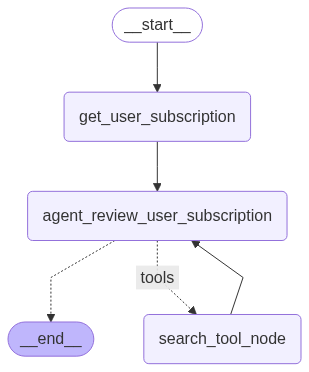

In [78]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))


## Testing Agent

In [79]:
config = {"configurable": {"thread_id": "1"}}

question = "What is the most expensive subscriptions and their names that Bob is subscribed to and what is the name of that service?"


result = agent.stream({"messages": [{"role": "user", "content": question}], "user_id": 1, "web_search_count": 0}, config=config, stream_mode="values")

# print(result['messages'])
for message in result:
    message["messages"][-1].pretty_print()



================================ Human Message =================================

What is the most expensive subscriptions and their names that Bob is subscribed to and what is the name of that service?
================================ Human Message =================================

What is the most expensive subscriptions and their names that Bob is subscribed to and what is the name of that service?
content='' additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-918a2e9bae5149688ebad65fb68648ae', 'type': 'function', 'function': {'name': 'web_search', 'arguments': '{"__arg1": "Adobe Creative Cloud"}'}}]} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 786, 'total_tokens': 810}, 'model_name': 'ibm/granite-3-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'} id='chatcmpl-23911aad-58b3-4ee4-8de4-b0b2d8a8840b---8dd09cbf2e71b92847600651a796e2aa---2ab6c2ea-5d32-4221-ad61-2f729eaa0406' tool_calls=[{'name': 'web_search', 'args': {'__arg1'